# Chapter 5 | Case Study A | **What Likelihood of Loss to Expect on a Stock Portfolio?** #

In this notebook, I'll be taking notes of the author's code on the referred case study. The goal is to reproduce the code in the original case studies repo. We shall delve into the topic of **generalization**, a fascinating subject when it comes to making estimates using the past. We will be using the <code>sp500</code> dataset. Later, on a separate case study, we will try to create our own model on other data sources.
## 1. Read the data ##

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = f"{current_path}/"

# Get location folders
data_in = f"{dirname}da_data_repo/sp500/clean/"
data_out = f"{dirname}da_case_studies/ch05-stock_market_loss_generalize/data/clean/"
output = f"{dirname}da_data_exercises/ch05-stock_market_loss_generalize/output/"
func = f"{dirname}da_case_studies/ch00-tech_prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions 
from py_helper_functions import *

### Question and data ##
The case study aims to assess the **likelihood** of experiencing a **loss of a certain magnitude** on an **investment portfolio** from **one day to the next day**. We want to guess the *frequency* of such a loss for the *coming* calendar year.

In [4]:
sp500 = (
    pd.read_csv(data_in + "SP500_2006_16_data.csv")
    .replace("", np.nan)
    .replace("#N/A", np.nan)
)
sp500 = sp500.dropna().reset_index(drop=True)

The investment portfolio in this case study is the **S&P500**, a stock market index based on companies listed on the NY Stock Exchange and Nasdaq. It represents the weighted average of the price of the 500 company shares.

The data includes day-to-day returns on the S&P500, defined as **percentage changes** in the closing price of the index between **two consecutive days**. It covers:
- 11 years
    - Starting with August 25, 2006
    - Ending with August 26, 2016

Because there were days in which the markets were closed, no observations existed. These were removed.

Let's take a quick look at the dataset.


In [5]:
sp500.head()

,DATE,VALUE
0,2006-08-25,1295.09
1,2006-08-28,1301.78
2,2006-08-29,1304.28
3,2006-08-30,1304.27
4,2006-08-31,1303.82


## 2. Data preprocessing ##
Let's create a percent return variable that indicates the percentage change on a daily basis.

In [5]:
sp500["pct_return"] = (
    (sp500["VALUE"] - sp500.set_index("DATE").shift(1).reset_index(drop=True)["VALUE"])
    /
    sp500.set_index("DATE").shift(1).reset_index(drop=True)["VALUE"] 
    * 100
)

In [6]:
sp500.head()

,DATE,VALUE,pct_return
0,2006-08-25,1295.09,NaN
1,2006-08-28,1301.78,0.516566
2,2006-08-29,1304.28,0.192045
3,2006-08-30,1304.27,-0.000767
4,2006-08-31,1303.82,-0.034502


In [7]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        2519 non-null   object 
 1   VALUE       2519 non-null   float64
 2   pct_return  2518 non-null   float64
dtypes: float64(2), object(1)
memory usage: 59.2+ KB


Because we are dealing with a time series dataset, we can perform a few transformations on `DATE` to obtain separate `year`, `month`, and `yearmonth` variables.

In [8]:
sp500["DATE"] = pd.to_datetime(sp500["DATE"], format="%Y-%m-%d")
sp500["year"] = sp500["DATE"].apply(lambda x: x.year)
sp500["month"] = sp500["DATE"].apply(lambda x: x.month)
sp500["yearmonth"] = sp500["year"] * 100 + sp500["month"]


In [9]:
sp500.head()

,DATE,VALUE,pct_return,year,month,yearmonth
0,2006-08-25,1295.09,NaN,2006,8,200608
1,2006-08-28,1301.78,0.516566,2006,8,200608
2,2006-08-29,1304.28,0.192045,2006,8,200608
3,2006-08-30,1304.27,-0.000767,2006,8,200608
4,2006-08-31,1303.82,-0.034502,2006,8,200608


Let's now plot the histogram of daily returns (in percentage points), annotating our definition of a large day-to-day loss, hereby defined as any loss **exceeding 5%**.

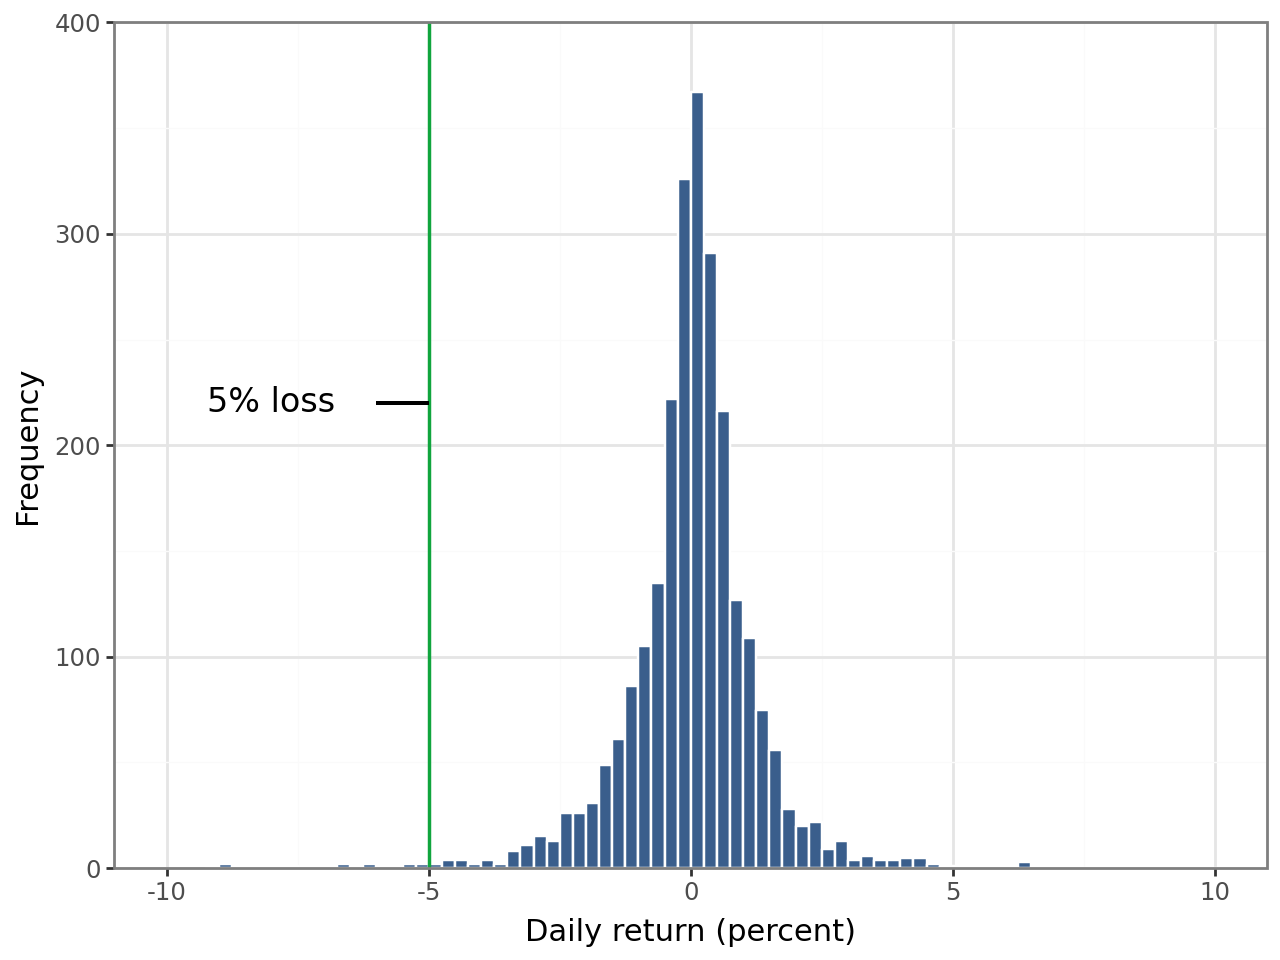

In [10]:
ggplot(sp500, aes("pct_return")) + geom_histogram(
    binwidth=0.25, color="white", fill=color[0], boundary=0, closed="left"
) + geom_vline(xintercept=-5, size=0.7, color=color[1]) + labs(
    x="Daily return (percent)", y="Frequency"
) + coord_cartesian(
    xlim=[-10, 10], ylim=[0, 400]
) + scale_y_continuous(
    expand=[0, 0]
) + geom_segment(
    aes(x=-6, y=220, xend=-5, yend=220)
) + annotate(
    "text", x=-8, y=220, label="5% loss", size=12
) + theme_bw()

While we can affirm that the proportion of losses exceeding 5% is fairly small, we cannot say right how small it is - or if it is *that* small. Let's return the number of days in which this threshold has been exceeded.

In [12]:
days_below_5pct = len(sp500.loc[sp500["pct_return"] <= -5, :])

days_below_5pct_proport = (days_below_5pct / sp500.shape[0]) * 100
print(f"There were {days_below_5pct} days in which sp500 returned a daily loss exceeding 5%. \nThis represents {days_below_5pct_proport:.1f}% of the total of days ({sp500.shape[0]}).")

There were 13 days in which sp500 returned a daily loss exceeding 5%. 
This represents 0.5% of the total of days (2519).


## 3. Repeated samples, standard error ##
We will now perform a simulation exercise to exemplify the ida of the sampling distribution. Taking the true value as 5% (the number of days with 5%+ losses), we can try to uncover this true value if we did not had the entire population data (considering for the sake of this experiment the 11years is the entire population data).

In [13]:
# Remove NaN values from `pct_return`
pct_return = sp500["pct_return"].dropna()

We can now create samples based on the assumption that we only have 4 years of data. Considering that each year has roughly 250 working days, we can use `1000` as our sample for this time spam. 

In [14]:
def create_samples(vector, n_samples, n_obs):
    samples_pctloss = [None] * (n_samples + 1)
    for i in range(1, n_samples + 1):
        single_sample = np.random.choice(vector, size=n_obs, replace=False)
        samples_pctloss[i] = sum(single_sample < -5) / n_obs * 100
    return samples_pctloss

Now, we can generate samples for 1000 and 500 observations. It is important to mention that, in our case, we are ignoring any dependence from a given value to the previous observations. That is, we are destroying the time-series component of our dataset for the purpose of understanding the process of generalizing from data.

In [15]:
np.random.seed = 123
n_obs_1000 = create_samples(pct_return, 10000, 1000)
n_obs_500 = create_samples(pct_return, 10000, 500)

In [16]:
n_obs_df = pd.DataFrame({"n_obs_500": n_obs_500, "n_obs_1000": n_obs_1000}).drop(0)

In [17]:
n_obs_df

,n_obs_500,n_obs_1000
1,0.6,0.7
2,0.4,0.5
3,0.2,0.6
4,1.0,0.1
5,0.6,0.2
...,...,...
9996,0.2,0.6
9997,0.8,0.6
9998,0.0,0.7
9999,0.6,0.5


Remember the **standard error** formula:
$SE_x = S /\sqrt{n}$

- `norm.ppf()` takes a percentage and returns a standard deviation multiplier for what value that percentage occurs at. 
- Then, this value is multiplied by the standard deviation for each value. Here, we are getting the standard deviation. 
- It will be divided by the squared root of the number of observations.

In [18]:
test = norm.ppf(0.975)
test

1.959963984540054

In [19]:
error = norm.ppf(0.975) * np.std(n_obs_df["n_obs_1000"]) / np.sqrt(len(n_obs_df["n_obs_1000"]))
left = np.mean(n_obs_df["n_obs_1000"]) - error
right = np.mean(n_obs_df["n_obs_1000"]) + error

Here, we get the mean of our sample and add and subtract the error for each variable.

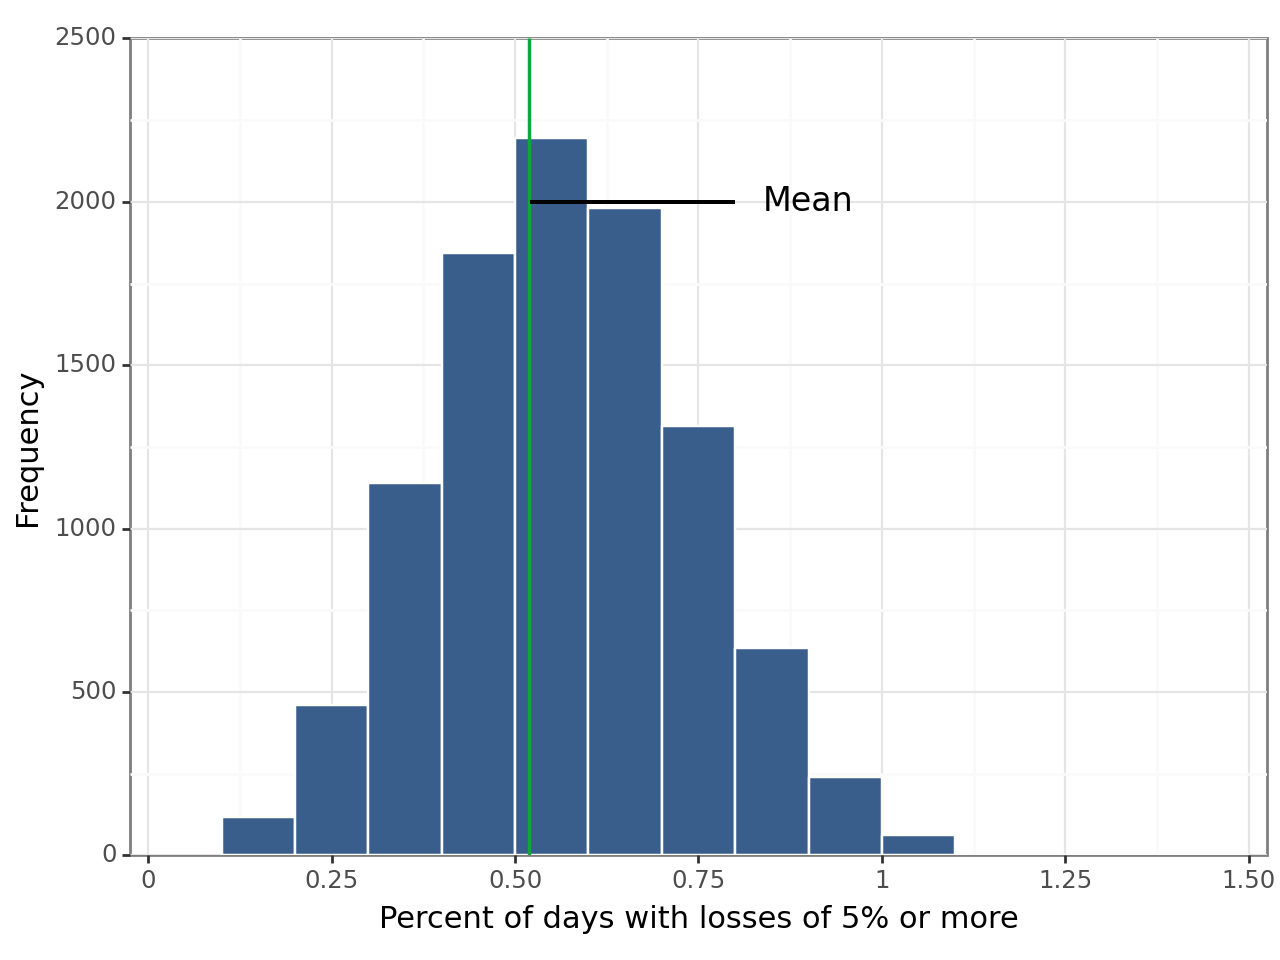

<Figure Size: (640 x 480)>

In [20]:
ggplot(n_obs_df, aes(n_obs_1000[1:])) + geom_histogram(
    binwidth=0.1, color="white", fill=color[0], alpha=0.8, center=0.75, closed="left"
) + labs(x="Percent of days with losses of 5% or more", y="Frequency") + geom_vline(
    aes(xintercept=np.mean(pd.Series(n_obs_500).dropna())), color=color[1], size=0.7
) + coord_cartesian(
    xlim=[0, 1.5], ylim=(0, 2500)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 1.5), breaks=seq(0, 1.6, 0.25)
) + scale_y_continuous(
    expand=(0.00, 0.00), limits=(0, 2500), breaks=seq(0, 2501, 500)
) + geom_segment(
    aes(x=0.8, y=2000, xend=0.52, yend=2000)
) + annotate(
    "text", x=0.9, y=2000, label="Mean", size=12
) + theme_bw()

In [21]:
error

0.003446141174968263

In [22]:
standard_error = np.std(n_obs_df["n_obs_1000"])
standard_error

0.17582676019309462

Our standard error for the sample is 0.17%, which means that we can expact to be 0.17% off from the mean across samples. Because this is the standard distribution over the fraction of 5%+ losses, we are dealing with the standard error.

In [23]:
n_obs_df.describe()

,n_obs_500,n_obs_1000
count,10000.000000,10000.000000
mean,0.518420,0.517520
std,0.287606,0.175836
min,0.000000,0.000000
25%,0.400000,0.400000
50%,0.400000,0.500000
75%,0.600000,0.600000
max,1.800000,1.100000


**Sampling properties**:
- The average of the values in repeated samples is approximately **equal to its true value** (the value in the entire population, or general pattern, represented by our data).
    - This is called **unbiasedness**. 
- The sampling distribution is approximately normal.
    - **Asymptotic normality**
- The standard error is **smaller** in the **larger sample**.
    - **Root-n convergence**. The standard error is **inversely proportional** to the **square root of the sample size**.
    - So, in very large samples, the standard deviation can shrink to zero.

## Sampling distribution with different sample sizes ##
How does the spread of the distribution behave when using different sample sizes? We can now plot a histogram with samples of 500 days and compare its distribution with that of a sample of n=1000. First, we can plot the kernel density estimator.

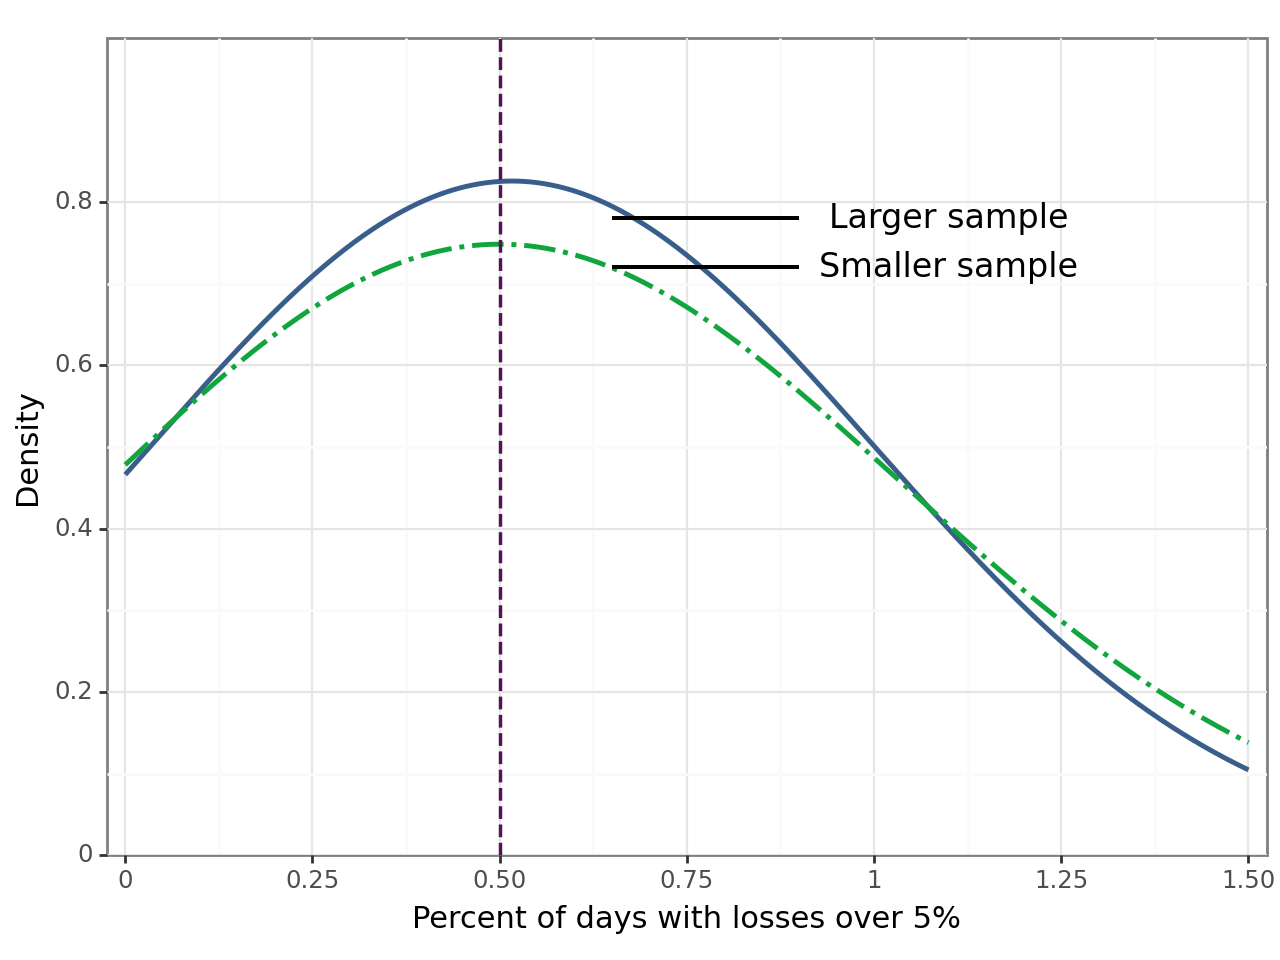

<Figure Size: (640 x 480)>

In [24]:
ggplot(n_obs_df) + stat_density(
    aes(x="n_obs_1000"), color=color[0], geom="line", bw=0.45, size=1
) + stat_density(
    aes("n_obs_500"), color=color[1], geom="line", bw=0.45, linetype="dashdot", size=1
) + labs(
    x="Percent of days with losses over 5%", y="Density"
) + geom_vline(
    xintercept=0.5, color=color[2], size=0.7, linetype="dashed"
) + geom_segment(
    aes(x=0.9, y=0.72, xend=0.65, yend=0.72),
    size=0.5
) + annotate(
    "text", x=1.1, y=0.78, label="Larger sample", size=12
) + geom_segment(
    aes(x=0.9, y=0.78, xend=0.65, yend=0.78), size=0.5
) + annotate(
    "text", x=1.1, y=0.72, label="Smaller sample", size=12 
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 1.5), breaks=seq(0, 1.51, 0.25)
) + scale_y_continuous(
    expand=(0.00, 0.00), limits=(0, 1), breaks=seq(0, 0.81, 0.2)
) + theme_bw() + theme(
    legend_position="none"
)

Now, we can plot the histogram.

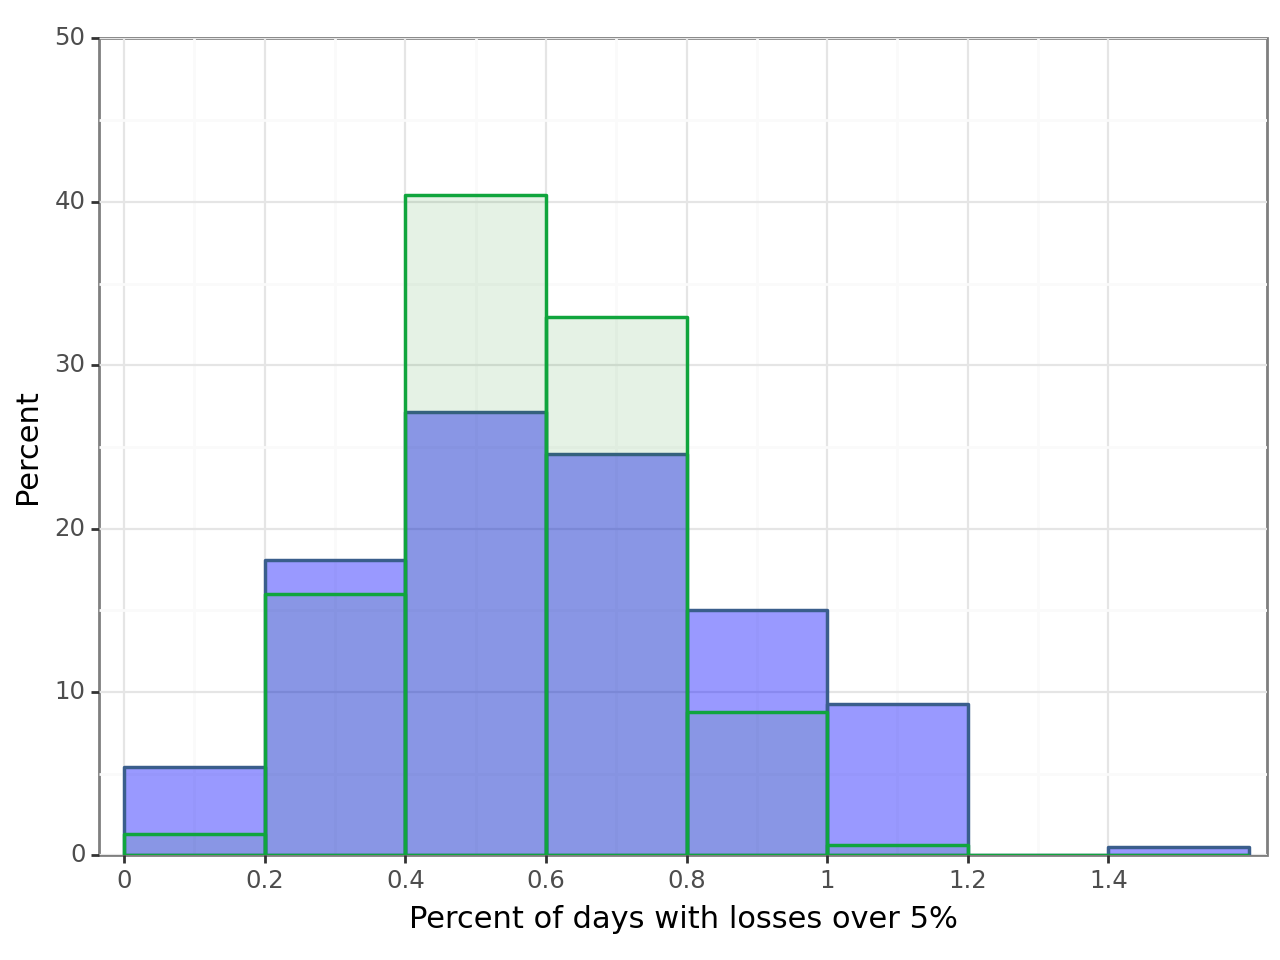

<Figure Size: (640 x 480)>

In [25]:
ggplot(n_obs_df) + geom_histogram(
    aes(x="n_obs_500", y="stat(count)/sum(stat(count))*100"),
    color=color[0],
    fill="blue",
    binwidth=0.2,
    center=0.5,
    size=0.7,
    alpha=0.4,
    closed="left",
) + geom_histogram(
    aes(x="n_obs_1000", y="stat(count)/sum(stat(count))*100"),
    color=color[1],
    fill="green",
    binwidth=0.2,
    center=0.5,
    alpha=0.1,
    size=0.7,
    closed="left",
) + ylab(
    "Percent"
) + xlab(
    "Percent of days with losses over 5%"
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(-0.01, 1.6), breaks=seq(0, 1.6, 0.2)
) + scale_y_continuous(
    expand=(0.00, 0.00), limits=(0, 50)
) + scale_color_manual(
    labels=("N = 1000", "N = 500"), name="", values=(color[1], color[0])
) + scale_alpha_identity() + scale_fill_identity() + theme_bw() + theme(
    legend_direction="horizontal",
)

In [26]:
n_obs_df.describe()

,n_obs_500,n_obs_1000
count,10000.000000,10000.000000
mean,0.518420,0.517520
std,0.287606,0.175836
min,0.000000,0.000000
25%,0.400000,0.400000
50%,0.400000,0.500000
75%,0.600000,0.600000
max,1.800000,1.100000


With 500 observations, more of the estimates are in the **smallest** and **largest** bins, while fewer of the estimates are in than in the middle bins, when compared to the sample with 1000 observations. While their mean is very similar, we can notice the difference on the **standard deviation** of each N: confirming one of the properties of sampling, n=1000 is nearly half of n=500. As such, the distribution of the latter is more skewed than the former's.

## Bootstramp standard error estimation ##
Going back to our task, our goal was:
- To estimate the CI for the proportion of days with large negative returns.
- We estimate that proportion from the data - we know that it is 0.5%.
Then, we estimate its standard error.

Following, we measure plus and minus two SE around this 0.5% value. We will get the 95% CI that tells us where to expect tha majority of days with large negative returns in the general pattern represented by our data.

Now, we can estimate the SE by boostrap. We calculate the proportions of days with 5%+ loss in each sample. We save this value, go back o the original data and take another bootstramp sample, calculating this same proportion of losses and saving this value once again. We end up with a new data table, in which one observation stands for one bootstrap sample. 


In [27]:
# Bootstrap samples
np.random.seed=573164
M = 10000
results = np.zeros((M, 10))

We created an array based on the number of observations (10000) and columns (10).

In [30]:
for i in range(1, M+1):
    bsample = np.random.choice(sp500["pct_return"], size=sp500.shape[0], replace=True)
    for j in range(1, 11):
        loss = pd.Series(bsample<(-j)).apply(lambda x: float(x))*100
        results[i -1, j - 1] = np.mean(loss)

In [38]:
sp500.shape[0]

2519

Steps:
- Now, we iterated over the range given by 1 to 10000, which is the number of bootstrap samples. Each sample is a random selection of `pct_return`. `size=sp500.shape[0]` means that we are taking a sample that is the size of our original population (2519), returning an array.
- Then, we perform another loop, this time, using the number of columns (1 to 10). 
- `loss` is a `pd.Series` based on Booleans - if `bsample < -j` (for instance, `-1` in the first iteration), the value is `True`. So basically we have a Series of booleans with the size of our sample.
- After that, `.apply()` applies (duh) a function to each element in the Boolean series that converts `True` to `1.0` and `False` to `0.0`. This value is then multiplied by 100. 
- Then, we select a row and a column from the array that had been created with zeroes (`results`). The row is `i` and the column, `j`. In each element, we will store the `mean` of `loss` using `np.mean(loss)`.

The result will be stored in a DataFrame with 10 columns. `loss1`, for instance, returns the percentage point of the mean of each boostrap sample where losses were at least below -1%. This logic is applied to the rest of the variables.


In [39]:
results = pd.DataFrame(
    results,
    columns=[
        "loss1",
        "loss2",
        "loss3",
        "loss4",
        "loss5",
        "loss6",
        "loss7",
        "loss8",
        "loss9",
        "loss10",
    ]
)

In [40]:
results

,loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8,loss9,loss10
0,15.125050,4.803493,1.548233,0.674871,0.357285,0.238190,0.119095,0.039698,0.039698,0.0
1,13.418023,5.557761,1.905518,1.071854,0.635173,0.277888,0.158793,0.119095,0.039698,0.0
2,14.092894,4.882890,1.627630,0.833664,0.238190,0.079397,0.079397,0.039698,0.000000,0.0
3,13.576816,5.081382,1.746725,0.992457,0.396983,0.317586,0.158793,0.119095,0.039698,0.0
4,12.822549,4.287416,1.905518,1.389440,0.714569,0.238190,0.119095,0.119095,0.039698,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,13.735609,5.160778,2.262803,1.111552,0.436681,0.357285,0.238190,0.158793,0.119095,0.0
9996,14.767765,5.001985,2.143708,1.270345,0.635173,0.436681,0.158793,0.119095,0.000000,0.0
9997,13.775308,4.962287,1.905518,0.833664,0.436681,0.238190,0.238190,0.198491,0.079397,0.0
9998,12.544661,4.843192,1.627630,0.833664,0.238190,0.119095,0.079397,0.079397,0.079397,0.0


Now, we want to know the estimated proportion of observations with 5%+ losses. Let's delve into the statistics of `loss5` before plotting the histogram.

In [41]:
results["loss5"].describe()


count    10000.000000
mean         0.516225
std          0.142314
min          0.039698
25%          0.436681
50%          0.516078
75%          0.595474
max          1.151250
Name: loss5, dtype: float64

In [46]:
pd.DataFrame.from_dict(
    {
        "Statistics": [
            "Mean",
            "Standard deviation",
            "Min percentage",
            "Max percentage",
            "25% quantile",
            "Median",
            "75% quantile",
            "Number of observations",
        ],
        "Value": [
            results["loss5"].describe()["mean"],
            results["loss5"].describe()["std"],
            results["loss5"].min(),
            results["loss5"].max(),
            results["loss5"].quantile(0.25),
            results["loss5"].median(),
            results["loss5"].quantile(0.75),
            results["loss5"].describe()["count"],
        ],
    }
).round(2)

,Statistics,Value
0,Mean,0.52
1,Standard deviation,0.14
2,Min percentage,0.04
3,Max percentage,1.15
4,25% quantile,0.44
5,Median,0.52
6,75% quantile,0.60
7,Number of observations,10000.00


We can see how the mean is really close to the true value of our original population, `0.5%`. Out of 10000 iterations, we got values as low as 0.04% and as high as 1.15%. Because the mean is so close to the median, we can expect a normal distribution. Let's find out.

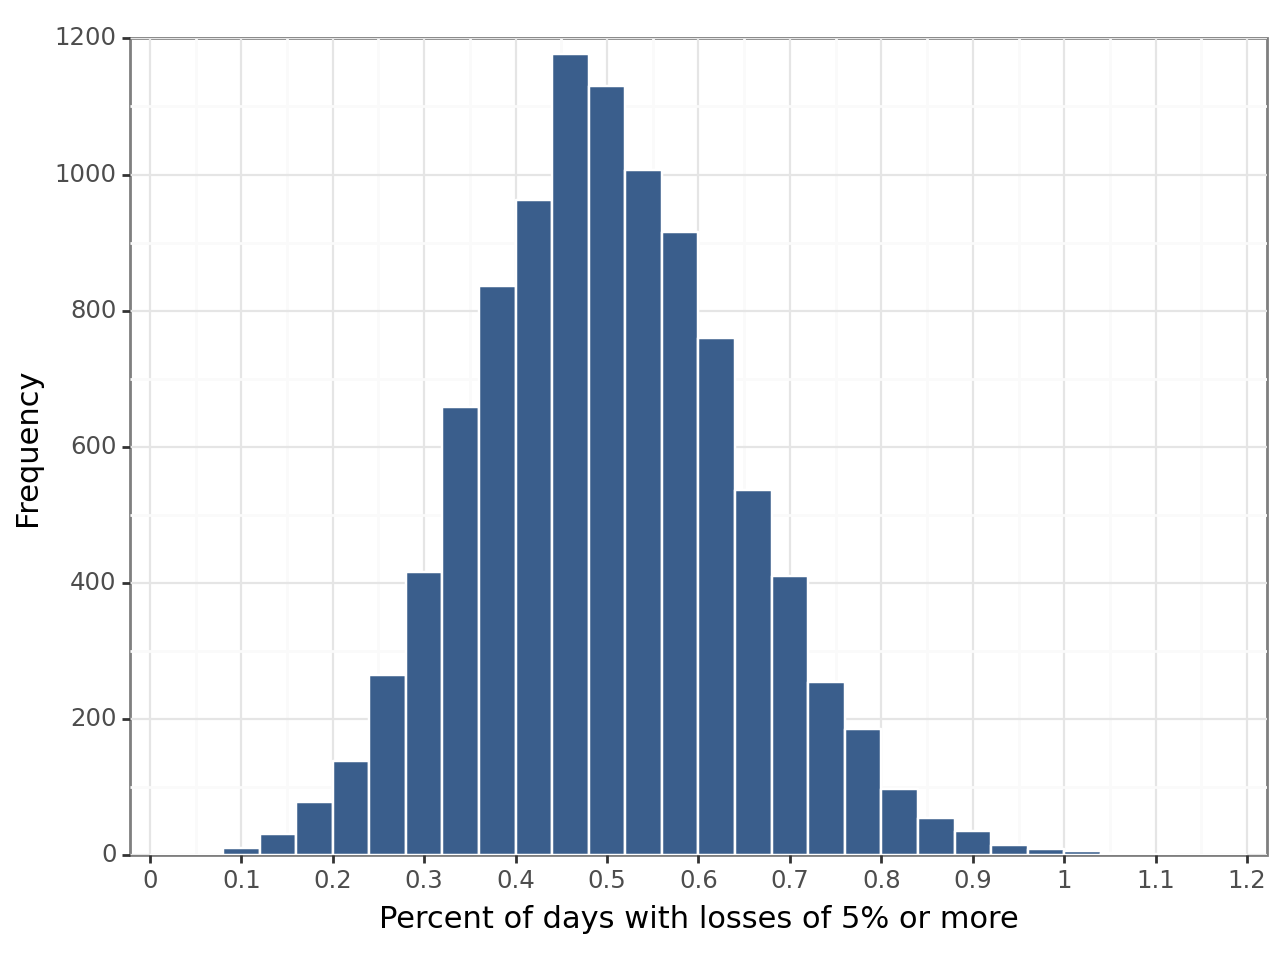

<Figure Size: (640 x 480)>

In [61]:
ggplot(results, aes("loss5")) + geom_histogram(
    fill=color[0], color="white", binwidth=0.04, boundary=0, closed="left"
) + scale_y_continuous(
    expand=(0, 0), limits=(0, 1200), breaks=seq(0, 1201, 200)
) + scale_x_continuous(
    expand=(0.01, 0.01), limits=(0, 1.2), breaks=seq(0, 1.21, 0.1)
) + labs(
    x="Percent of days with losses of 5% or more", y="Frequency"
) + theme_bw()

Yeah, there you have it. And since the goal of this exercise was to obtain the standard error of the statistics, we can now confirm that its value is **0.14**: this is the bootstrap SE estimate.

## 5. Findings ##

With this, we can construct our confidence interval:
- The 95% CI is 0.5% +- 2 * 0.14. This means [0.22% and 0.78%]
- In the general pattern represented by the 11-year history of returns in our data, we can be **95% confident** that the chance of daily losses of more than 5% is **somewhere between 0.22% and 0.78%**.


## Extra: Getting the SE with the formula ##
Remember the **standard error** formula:

$SE_x = S /\sqrt{n}$

We can use our original data and obtain the standard error.

In [51]:
sp500["pct_return"].sample()

1226   -1.809049
Name: pct_return, dtype: float64

In [65]:
mean_std_loss5 =(sp500["pct_return"] < -5).mean()
n_obs = sp500.shape[0]

std_error = np.sqrt(mean_std_loss5 * (1 - mean_std_loss5) / n_obs)
std_error
print(f"The standard error for the number of days with 5%+ loss is {std_error*100:.2f}%")

The standard error for the number of days with 5%+ loss is 0.14%


We obtained the same value as from our boostrap exercise. Let's calculate the 95% CI.

In [71]:
Z = 2
CI_lower = (mean_std_loss5 - Z * std_error) * 100
CI_upper = (mean_std_loss5 + Z * std_error) * 100

print(f"The 95% CI is [{CI_lower.round(2), CI_upper.round(2)}]")



The 95% CI is [(0.23, 0.8)]
